# Sharpe Ratio Heat‑Map Notebook 🚀

This notebook walks you through **parameter‑sweeping the back‑test** so you can
visualise how the Sharpe ratio responds to two key levers:

* **`top_n`** – how many of the highest‑ranked stocks you long each rebalance.
* **`hold_days`** – how long you keep each position open.

The workflow mirrors the CLI pipeline (`run_efa.py`) but exposes the steps so
you can iterate interactively.

> **Runtime:** With the default 3×3 grid (≈9 back‑tests) it finishes in a couple
> of minutes on a typical laptop.  Expand the lists to explore a finer mesh.


In [1]:
# <AUTOGEN_PATH_SETUP>
# 🚀 Robustly set project root: strip the trailing "notebooks" folder (works cross-platform).
import sys
import os
from pathlib import Path

NOTEBOOK_DIR = Path.cwd().resolve()

# If the path contains a 'notebooks' folder, drop everything at/after it.
if "notebooks" in NOTEBOOK_DIR.parts:
    nb_index = NOTEBOOK_DIR.parts.index("notebooks")
    PROJECT_ROOT = Path(*NOTEBOOK_DIR.parts[:nb_index])
else:
    PROJECT_ROOT = NOTEBOOK_DIR.parent  # fallback

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

os.chdir(PROJECT_ROOT)
print("🗂 Working dir set to project root:", PROJECT_ROOT)

🗂 Working dir set to project root: /Users/wadoudcharbak/Documents/GitHub/Quant_Project/Equity_Factor_Alpha


In [ ]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Project modules
from src.config import cfg
from src.data_loader import get_all_equities
from src.features import add_returns, add_rolling_features, prepare_feature_matrix
from src.model import train_model, predict
from src.backtest import run_backtest

# Silence chatty loggers
logging.getLogger().setLevel(logging.WARNING)

# -----------------------
# Sharpe heat‑map grid
top_n_list = np.arange(5, 31)  # x‑axis of the heat‑map
hold_list = np.arange(5, 31)  # y‑axis

print("Parameter grid:", len(top_n_list), "×", len(hold_list))

Parameter grid: 26 × 26


In [9]:
# ==== Load configuration ====
p = cfg()
base_currency = p.get("base_currency", "GBP").upper()

# ==== Data acquisition ====
tickers = [a["ticker"] for a in p["assets"]]
data = get_all_equities(start_date=p.get("start_date"), end_date=p.get("end_date"))
data = {t: df for t, df in data.items() if t in tickers}

# ==== Feature engineering ====
processed = {}
for t, df in data.items():
    df = add_returns(df, price_col="close", out_col=p["features"]["return_col"])
    df = df.dropna(subset=[p["features"]["return_col"]])
    df = add_rolling_features(
        df, col=p["features"]["return_col"], windows=p["features"]["windows"]
    )
    processed[t] = df

X, y = prepare_feature_matrix(
    processed,
    windows=p["features"]["windows"],
    lookahead=1,
    return_col=p["features"]["return_col"],
)
benchmark = y.groupby(level=0).mean()

# ==== Model ====
model, rmse = train_model(X, y, params=p["model"], test_size=0.2)
preds = predict(model, X)

print(f"Model fitted (validation RMSE = {rmse:.6f})")

Model fitted (validation RMSE = 0.018406)


In [10]:
results = {}
constant_kwargs = dict(
    predictions=preds,
    returns=y,
    benchmark_returns=benchmark,
    risk_free_rate=p["backtest"].get("risk_free_rate", 0.0),
    fee_bps=p["backtest"]["fee_bps"],
    notional=p["backtest"]["notional"],
)

for hold in hold_list:
    for top_n in top_n_list:
        res = run_backtest(**constant_kwargs, hold_days=hold, top_n=top_n)
        sharpe = res["metrics"]["sharpe"]
        results[(hold, top_n)] = sharpe
        print(f"hold={hold}, top_n={top_n} → Sharpe {sharpe:.3f}")

heat = (
    pd.Series(results)
    .unstack()  # rows = hold_days, cols = top_n
    .sort_index()
)
heat

hold=5, top_n=5 → Sharpe -0.876
hold=5, top_n=6 → Sharpe -0.864
hold=5, top_n=7 → Sharpe -0.832
hold=5, top_n=8 → Sharpe -0.832
hold=5, top_n=9 → Sharpe -0.832
hold=5, top_n=10 → Sharpe -0.832
hold=5, top_n=11 → Sharpe -0.832
hold=5, top_n=12 → Sharpe -0.832
hold=5, top_n=13 → Sharpe -0.832
hold=5, top_n=14 → Sharpe -0.832
hold=5, top_n=15 → Sharpe -0.832
hold=5, top_n=16 → Sharpe -0.832
hold=5, top_n=17 → Sharpe -0.832
hold=5, top_n=18 → Sharpe -0.832
hold=5, top_n=19 → Sharpe -0.832
hold=5, top_n=20 → Sharpe -0.832
hold=5, top_n=21 → Sharpe -0.832
hold=5, top_n=22 → Sharpe -0.832
hold=5, top_n=23 → Sharpe -0.832
hold=5, top_n=24 → Sharpe -0.832
hold=5, top_n=25 → Sharpe -0.832
hold=5, top_n=26 → Sharpe -0.832
hold=5, top_n=27 → Sharpe -0.832
hold=5, top_n=28 → Sharpe -0.832
hold=5, top_n=29 → Sharpe -0.832
hold=5, top_n=30 → Sharpe -0.832
hold=6, top_n=5 → Sharpe -0.856
hold=6, top_n=6 → Sharpe -0.850
hold=6, top_n=7 → Sharpe -0.815
hold=6, top_n=8 → Sharpe -0.815
hold=6, top_n=9 → S

,5,6,7,8,9,10,11,12,13,14,...,21,22,23,24,25,26,27,28,29,30
5,-0.876411,-0.864136,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,...,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288,-0.832288
6,-0.856419,-0.850470,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,...,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684,-0.814684
7,-0.853411,-0.847462,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,...,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471,-0.812471
8,-0.851393,-0.846246,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,...,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820,-0.810820
9,-0.847682,-0.843107,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,...,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219,-0.807219
10,-0.845230,-0.840239,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,...,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190,-0.804190
11,-0.843711,-0.838086,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,...,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318,-0.802318
12,-0.841841,-0.836263,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,...,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088,-0.800088
13,-0.840211,-0.834683,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,...,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380,-0.798380
14,-0.838335,-0.832799,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,...,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010,-0.796010


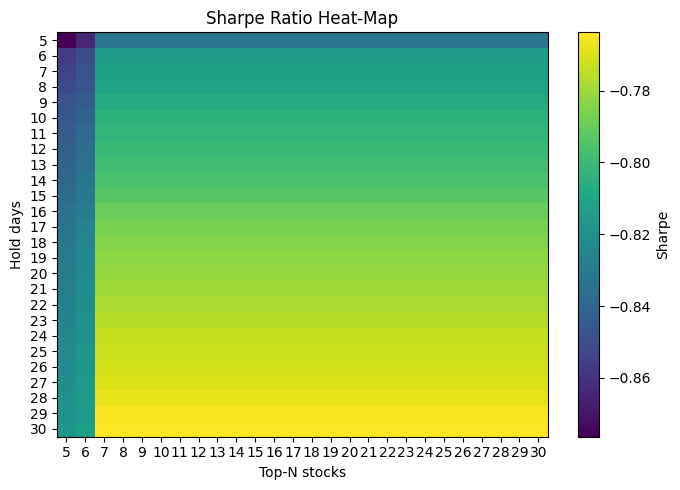

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(heat, aspect="auto")
ax.set_xticks(range(len(heat.columns)))
ax.set_xticklabels(heat.columns)
ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels(heat.index)
ax.set_xlabel("Top‑N stocks")
ax.set_ylabel("Hold days")
ax.set_title("Sharpe Ratio Heat‑Map")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Sharpe")
plt.tight_layout()
plt.show()

### How to read the heat‑map

* **Bright cells → higher Sharpe**: combinations that historically delivered better risk‑adjusted returns.
* **Dark cells → lower Sharpe**: avoid these settings unless you have other reasons.

Remember to **validate the winning parameters on an out‑of‑sample period** to guard against data‑snooping.
